# Llama 2 vs Llama 3

### Import Libraries

In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp
import pandas as pd
import utils

from dotenv import load_dotenv
from generator.generator import Generator
from datasets import load_dataset

llama2 = Generator(model='llama2')
llama3 = Generator(model='llama3')

load_dotenv('env/var.env')

### Load Q&A Data 

In [3]:
squad = load_dataset("squad", split="train")
squad = squad.shuffle()

### Create dictionary to save metrics

In [4]:
llama2_metrics = {
    "words_per_second": [],
    "words": [],
    "rank": [],
}

llama3_metrics = {
    "words_per_second": [],
    "words": [],
    "rank": [],
}

### Gather metrics

In [ ]:
for i in range(30):
    context = squad[i]['context']
    query = squad[i]['question']
    answer = squad[i]['answers']['text'][0]

    # llama 2
    answer_llama2, words_per_second, words = utils.get_llm_response(llama2, context, query)
    llama2_metrics["words_per_second"].append(words_per_second)
    llama2_metrics["words"].append(words)

    # llama 3
    answer_llama3, words_per_second, words = utils.get_llm_response(llama3, context, query)
    llama3_metrics["words_per_second"].append(words_per_second)
    llama3_metrics["words"].append(words)

    # GPT-3.5 rank
    llm_answers_dict = {'llama2': answer_llama2, 'llama3': answer_llama3}
    rank = utils.get_gpt_rank(answer, llm_answers_dict, os.getenv("OPENAI_API_KEY"))

    llama2_metrics["rank"].append(rank.index('1')+1)
    llama3_metrics["rank"].append(rank.index('2')+1)
    

### Metrics comparison

#### Llama 2 7B vs Llama 3 8B

In [25]:
llama2_metrics = pd.DataFrame(llama2_metrics)
llama2_metrics['model'] = 'Llama 2 7B'
llama3_metrics = pd.DataFrame(llama3_metrics)
llama3_metrics['model'] = 'Llama 3 8B'

# create single data frame for plotting
metrics = pd.concat([llama2_metrics, llama3_metrics])

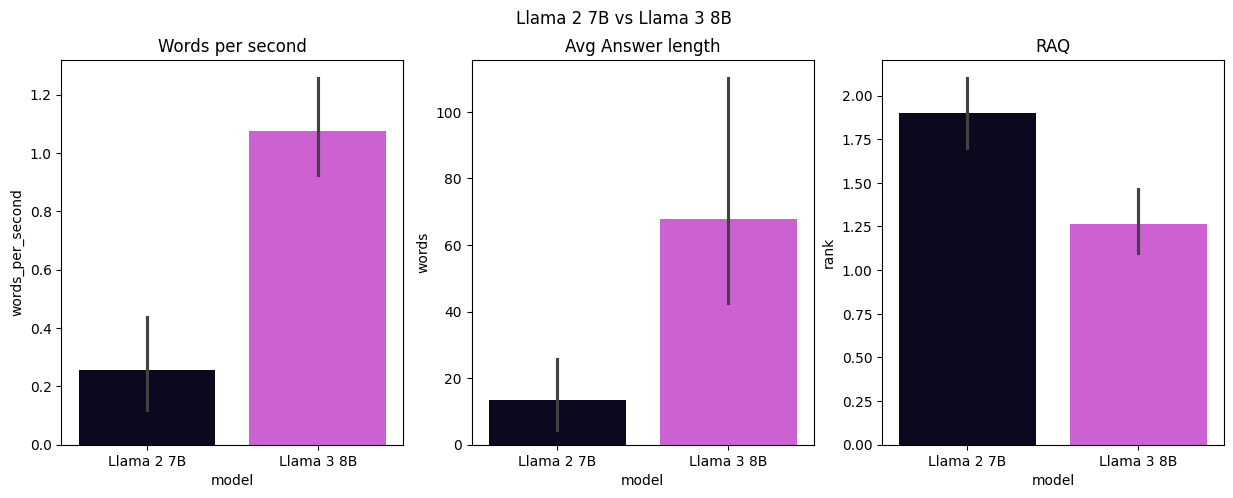

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Llama 2 7B vs Llama 3 8B')

sns.barplot(ax=axes[0], data=metrics, y='words_per_second', x='model', hue='model', palette=["#070620", "#dd4fe4"])
axes[0].set_title("Words per second")

sns.barplot(ax=axes[1], data=metrics, y='words', x='model', hue='model', palette=["#070620", "#dd4fe4"])
axes[1].set_title("Avg Answer length")

sns.barplot(ax=axes[2], data=metrics, y='rank', x='model', hue='model', palette=["#070620", "#dd4fe4"])
axes[2].set_title("RAQ")

plt.show()

# Statiscal Test
 - Check if p_values are higher than the level of significance:
    - false means that two groups are statistically different.

In [27]:
p_values = sp.posthoc_dunn([llama2_metrics['rank'], llama3_metrics['rank']], p_adjust='holm')
p_values > 0.05

,1,2
1,True,False
2,False,True
